In [ ]:
import os

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'sanyalshubhangi'
os.environ['KAGGLE_KEY'] = '72d84d5a28f6c325c6b829e9dffda06f'

In [ ]:
!kaggle competitions download -c planet-understanding-the-amazon-from-space

  0% 0.00/2.94M [00:00<?, ?B/s]
100% 2.94M/2.94M [00:00<00:00, 180MB/s]


In [ ]:
!unzip planet-understanding-the-amazon-from-space.zip

Archive:  planet-understanding-the-amazon-from-space.zip
replace Kaggle-planet-test-tif.torrent? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Kaggle-planet-test-tif.torrent  
  inflating: Kaggle-planet-train-tif.torrent  
  inflating: sample_submission_v2.csv/sample_submission_v2.csv  
  inflating: test_v2_file_mapping.csv/test_v2_file_mapping.csv  
  inflating: train_v2.csv/train_v2.csv  


In [ ]:
!kaggle datasets download -d nikitarom/planets-dataset

 99% 1.49G/1.50G [00:16<00:00, 101MB/s] 
100% 1.50G/1.50G [00:16<00:00, 95.8MB/s]


In [ ]:
!unzip planets-dataset.zip

In [ ]:
pip install tensorflow

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd
#import cv2, gc
import gc
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, InputLayer
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.backend import clear_session
import tensorflow as tf

import cv2
import os
from tqdm import tqdm

import time

from os import listdir
import csv

In [ ]:
input_size = 128
epochs = 10
dropout_rate = 0.5
batch_size = 128
shape = (input_size, input_size, 3)
path = '/content/planet/planet'
train_path = '/content/planet/planet/train-jpg'
test_path = '/content/planet/planet/test-jpg'
lr = 0.0001
reg_str = 0.01 # Regularization Strength
nfolds = 2 # No of folds for cross validation
workers = 4 # Multithreading no of threads
maxq = 10 # Max Queue size for multithreading
tresh = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

In [ ]:
df_train = pd.read_csv(f'/content/planet/planet/train_classes.csv')
df_test = pd.read_csv(f'/content/planet/planet/sample_submission.csv')

df_train['image_name'] = df_train['image_name'].astype(str) + '.jpg'
df_test['image_name'] = df_test['image_name'].astype(str) + '.jpg'

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

print(df_train.head())
print(df_test.head())

X_train_files = np.array(df_train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))

y_train = np.array(df_train['tags'].tolist())

    image_name                                       tags
0  train_0.jpg                               haze primary
1  train_1.jpg            agriculture clear primary water
2  train_2.jpg                              clear primary
3  train_3.jpg                              clear primary
4  train_4.jpg  agriculture clear habitation primary road
   image_name                                        tags
0  test_0.jpg  [primary, clear, agriculture, road, water]
1  test_1.jpg  [primary, clear, agriculture, road, water]
2  test_2.jpg  [primary, clear, agriculture, road, water]
3  test_3.jpg  [primary, clear, agriculture, road, water]
4  test_4.jpg  [primary, clear, agriculture, road, water]


In [ ]:
labels = []

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
        
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


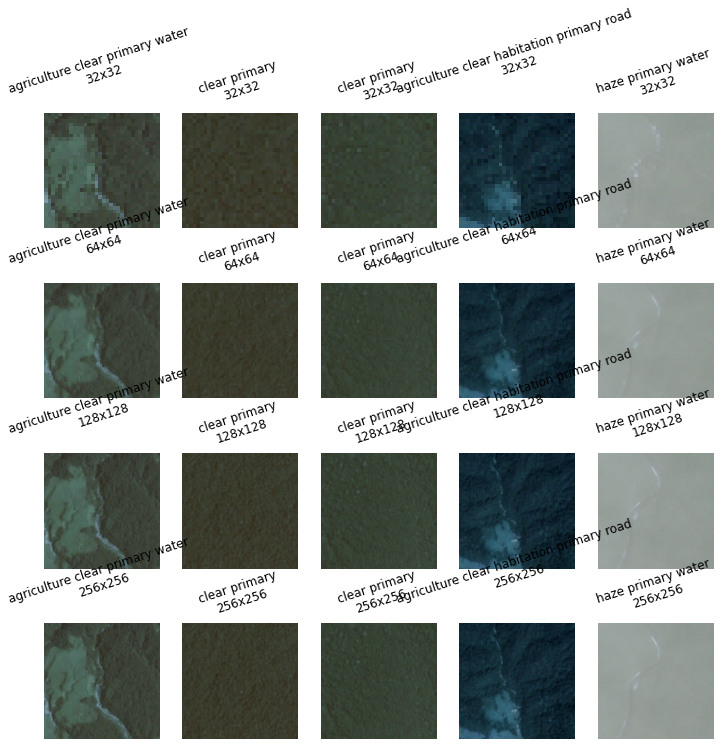

In [ ]:
plt.figure(figsize=(12, 12))
res = [32, 64, 128, 256]
NIMGS = 5

for i in range(len(res)):
    for j in range(NIMGS):
        img = cv2.imread(os.path.join(train_path,df_train['image_name'][j+1]))
        img = cv2.resize(img, (res[i], res[i]))
        plt.subplot(len(res), NIMGS, i*NIMGS+j+1)
        plt.imshow(img)
        plt.title(df_train['tags'][j+1] + "\n" + str(res[i]) + "x" + str(res[i]), rotation=18)
        plt.axis('off')
    
plt.show()

In [ ]:
def create_model():
    model = Sequential()
    model.add(InputLayer(shape))
    model.add(VGG16(weights='imagenet', include_top=False))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(17, activation='sigmoid'))
    return model

clear_session()

model = create_model()
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 4096)              33558528  
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                         

In [ ]:
def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

In [ ]:
num_fold = 0

y_test = []
y_test2 = []

folds = KFold(n_splits=nfolds, shuffle=True, random_state=1).split(X_train_files, y_train)

for train_index, val_index in folds:
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])
    
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=train_path,
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=train_path,
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=test_path,
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
        shuffle=False,
    )
    
    test_datagen2 = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator2 = test_datagen2.flow_from_dataframe(
        df_test,
        directory="/content/test-jpg-additional/test-jpg-additional",
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
        shuffle=False,
    )


    model_path_of_fold = os.path.join('', 'weights_of_fold_' + str(num_fold) + '.h5')
    
    clear_session()
    model = create_model()
    
    adam = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f2_score])
    
    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='val_f2_score', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]
    
    model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks,
                       workers=workers, use_multiprocessing=True, max_queue_size=maxq)

    model.load_weights(model_path_of_fold)

    p_test = model.predict(test_generator, workers=workers, use_multiprocessing=True, max_queue_size=maxq)
    y_test.append(p_test)
    
    p_test2 = model.predict(test_generator2, workers=workers, use_multiprocessing=True, max_queue_size=maxq)
    y_test2.append(p_test2)

Found 20239 validated image filenames belonging to 17 classes.
Found 20240 validated image filenames belonging to 17 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 20522 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 40669 validated image filenames belonging to 17 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 40669 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 20522 validated image filenames belonging to 17 classes.
Epoch 1/10
159/159 [==============================] - 17208s 108s/step - loss: 0.1975 - f2_score: 0.7323 - val_loss: 0.1477 - val_f2_score: 0.8370 - lr: 1.0000e-04
Epoch 2/10
 49/159 [========>.....................] - ETA: 2:41:02 - loss: 0.1489 - f2_score: 0.8199

In [ ]:
result1 = np.array(y_test[0])
for i in range(1, nfolds):
    result1 += np.array(y_test[i])
result1 /= nfolds
result1 = pd.DataFrame(result1, columns = labels)
result1.head()

In [ ]:
result2 = np.array(y_test2[0])
for i in range(1, nfolds):
    result2 += np.array(y_test2[i])
result2 /= nfolds
result2 = pd.DataFrame(result2, columns = labels)
result2.head()

In [ ]:
results = result1.append(result2, ignore_index=True)
results.shape

In [ ]:
preds = []
for i in range(results.shape[0]):
    a = results.iloc[[i]]
    a = a.apply(lambda x: x > tresh, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

In [ ]:
df_test['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
df_test.head()

In [ ]:
df_test['tags'] = preds

In [ ]:
fin = pd.DataFrame(df_test["image_name"])
fin.head()

In [ ]:
fin["tags"] = preds
fin.head()

In [ ]:
fin.to_csv('Amazon_multilabel.csv', index=False)